In [17]:
import pickle
import pandas as pd
import os
import glob
from IPython.display import display
import matplotlib.pyplot as plt
import re
import numpy as np

Reading the files with Market Iterations: These are for multiple auctions in one run


In [20]:
def read_pickle_file(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

In [ ]:
# Directing to the path where the results are stored adn read all the pickle files (Market 0 to end market), extracting the market times
# and storing the data in a list of dictionaries. The list is then converted to a DataFrame for easier visualization.
current_dir = os.getcwd()
parent_folder = os.path.abspath(os.path.join(current_dir, ".."))
folder_path = os.path.join(
    parent_folder,
    "results",
    "modified_bidbudget_toulouse_case3_withC_cap5_withReturn_3_highcap_fisher_b-50.0_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250204_111131",
    "results"
)


fisher_files = sorted(glob.glob(os.path.join(folder_path, "fisher_data_*.pkl")))
fisher_after_files = sorted(glob.glob(os.path.join(folder_path, "fisher_data_after_*.pkl")))

# Extract the market auction time from filenames
def extract_time(filename):
    return int(filename.split("_")[-1].split(".")[0])  # Extracts the number from fisher_data_X.pkl


fisher_data_list = []
after_fisher_data_list = []

# Iterate over paired files
for fisher_file, fisher_after_file in zip(fisher_files, fisher_after_files):
    fisher_data = read_pickle_file(fisher_file)
    end_of_market_data = read_pickle_file(fisher_after_file)

    if fisher_data is None or end_of_market_data is None:
        continue  # Skip if reading failed

    market_time = extract_time(fisher_file)

    # Extract necessary data from Fisher Market (Before Transactions)
    prices = fisher_data["prices"]
    goods_list = fisher_data["goods_list"]

    # Extract necessary data from End of Market (After Transactions)
    market_data = end_of_market_data["market_data"]
    agents_data = end_of_market_data["agents_data"]

    # Extract market-level data
    end_capacities = market_data["capacity"]
    initial_capacities = market_data["original_capacity"]
    end_prices = market_data["prices"]  # Prices after transactions (if they change)

    print(f"\n🔎 Processing Market Time: {market_time}")
    print(f"  📌 Found {len(fisher_data['desired_goods'])} agents")

    for agent, agent_data in fisher_data["desired_goods"].items():
        desired_indx = agent_data['desired_transit_edges_idx'][0]  # Directly access

        try:
            # Data before transactions (Fisher Market)
            fisher_data_list.append({
                "Market_Time": market_time,
                "Agent": agent,
                "Edge_Index": desired_indx,
                "Price": prices[desired_indx],  # Price before transaction
                "Initial_Capacity": initial_capacities[desired_indx],  # Starting capacity
                "Good": goods_list[desired_indx][1],
                "Data_Type": "Fisher"
            })

            # Extract agent-specific information after the market transaction
            agent_final_allocation = agents_data[agent].get("final_allocation", {})
            agent_payment = agents_data[agent].get("payment", 0)
            agent_valuation = agents_data[agent].get("valuation", {})

            # Data after transactions (After Fisher Market)
            after_fisher_data_list.append({
                "Market_Time": market_time,
                "Agent": agent,
                "Edge_Index": desired_indx,
                "Price": end_prices[desired_indx],  # Final price after auction
                "End_Capacity": end_capacities[desired_indx],  # Capacity after auction
                "Good": goods_list[desired_indx][1],
                "Final_Goods_allocated": agents_data[agent]["agent_goods_list"],  # Final goods allocated
                "Final_goods_vector": agent_final_allocation,
                "Payment": agent_payment,
                "Data_Type": "After_Fisher"
            })
        except KeyError as e:
            print(f"    ❌ Skipping {agent}: Key {e} not found in dataset!")

# Create DataFrames
df_fisher = pd.DataFrame(fisher_data_list)
df_after_fisher = pd.DataFrame(after_fisher_data_list)

# ## uncomment below if you want to see the entire dataframe
# # pd.set_option('display.max_rows', None)  # Show all rows
# # pd.set_option('display.max_columns', None)  # Show all columns
# # pd.set_option('display.width', 1000)  # Adjust width to prevent line breaks
# # pd.set_option('display.max_colwidth', None)  # Prevent column truncation
# # display(df)



In [ ]:
# Display high-level structure of data
print("📊 Summary of Fisher Market Data Structure:")
print("High-level data from End of Market:", list(end_of_market_data.keys()))
print("High-level data from Fisher Market:", list(fisher_data.keys()))

# DataFrame summaries
print("\n🗂 Fisher Market Data Overview:")
display(df_fisher.info())
display(df_fisher.sample(10))

print("\n🗂 After Fisher Market Data Overview:")
display(df_after_fisher.info())
display(df_after_fisher.sample(10))


In [ ]:
# Ensure Market_Time is an integer for proper sorting
df_fisher['Market_Time'] = df_fisher['Market_Time'].astype(int)

# Split "Good" into "Sector" and "Request_Time"
df_fisher[['Sector', 'Request_Time']] = df_fisher['Good'].str.split('_', expand=True)

# Convert Request_Time to integer
df_fisher['Request_Time'] = df_fisher['Request_Time'].astype(int)

# Group by Sector, Request_Time, and Market_Time while counting the number of agents
sector_request_counts = (
    df_fisher.groupby(['Sector', 'Request_Time', 'Market_Time'])['Agent']
    .count()
    .reset_index()
    .rename(columns={'Agent': 'Num_Agents'})
)

# Sort the DataFrame by Market_Time (ascending), Request_Time, and Sector (both descending)
sector_request_counts_sorted = sector_request_counts.sort_values(
    by=["Market_Time", "Request_Time", "Sector"], ascending=[True, True, True]
)

# Display DataFrame
pd.set_option('display.max_rows', None)
display(sector_request_counts_sorted)



## Plot Performance Data

In [21]:
current_dir = os.getcwd()
parent_folder = os.path.abspath(os.path.join(current_dir, ".."))

file_list = ["capacity_study/toulouse_case_cap13_updated_fisher_b-50.0_agents10_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_154841",
             "capacity_study/toulouse_case_cap13_updated_fisher_b-50.0_agents40_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_154851",
             "capacity_study/toulouse_case_cap13_updated_fisher_b-50.0_agents80_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_154921",
             "capacity_study/toulouse_case_cap13_updated_fisher_b-50.0_agents120_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_155023",
             "capacity_study/toulouse_case_cap13_updated_fisher_b-50.0_agents160_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_155212",
             "capacity_study/toulouse_case_cap13_updated_fisher_b-50.0_agents177_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_155448",
             "capacity_study/toulouse_case_cap10_updated_fisher_b-50.0_agents10_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_161400",
             "capacity_study/toulouse_case_cap10_updated_fisher_b-50.0_agents40_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_161410",
             "capacity_study/toulouse_case_cap10_updated_fisher_b-50.0_agents80_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_161440",
             "capacity_study/toulouse_case_cap10_updated_fisher_b-50.0_agents120_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_161756",
             "capacity_study/toulouse_case_cap10_updated_fisher_b-50.0_agents160_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_162731",
             "capacity_study/toulouse_case_cap10_updated_fisher_b-50.0_agents177_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_164125",
             "capacity_study/toulouse_case_cap7_updated_fisher_b-50.0_agents10_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_170323",
             "capacity_study/toulouse_case_cap7_updated_fisher_b-50.0_agents40_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_170335",
             "capacity_study/toulouse_case_cap7_updated_fisher_b-50.0_agents80_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_170543",
             "capacity_study/toulouse_case_cap7_updated_fisher_b-50.0_agents120_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_171238",
            "capacity_study/toulouse_case_cap7_updated_fisher_b-50.0_agents160_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_172828",
            "capacity_study/toulouse_case_cap7_updated_fisher_b-50.0_agents177_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_210343",
            "capacity_study/toulouse_case_cap4_updated_fisher_b-50.0_agents10_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_183540",
            "capacity_study/toulouse_case_cap4_updated_fisher_b-50.0_agents40_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_183549",
            "capacity_study/toulouse_case_cap4_updated_fisher_b-50.0_agents80_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_185000",
            "capacity_study/toulouse_case_cap4_updated_fisher_b-50.0_agents120_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_191252",
            "capacity_study/toulouse_case_cap4_updated_fisher_b-50.0_agents160_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_213948",
            "capacity_study/toulouse_case_cap4_updated_fisher_b-50.0_agents177_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_202205"

             

]


df_list = []

for file in file_list:
    folder_path = os.path.join(parent_folder, "results", file, "results")
    csv_file_path = os.path.join(folder_path, 'market_performance_table.csv')
    
    try:
        df_csv = pd.read_csv(csv_file_path)
        df_csv["File"] = file  # column to track file origin
        capacity = int(file.split('_cap')[1].split('_')[0])
        df_csv["Capacity"] = capacity
        df_list.append(df_csv)
    except FileNotFoundError:
        print(f"File not found: {csv_file_path}")
    except pd.errors.EmptyDataError:
        print(f"File is empty: {csv_file_path}")

# Concatenate all DataFrames
pd.set_option('display.max_rows', None) 
if df_list:
    combined_df = pd.concat(df_list, ignore_index=True)
    # display(combined_df.head())
    display(combined_df)
else:
    print("No data was loaded.")

 

,Market_Auction_Start_Time,Number_Interations,Number_Agents,Num_Goods,Number_Contested_Routes,Run_Time,File,Capacity
0,0,7,10,992,0,3.94628,capacity_study/toulouse_case_cap13_updated_fis...,13
1,0,8,40,2681,0,16.77201,capacity_study/toulouse_case_cap13_updated_fis...,13
2,0,8,80,4593,0,34.92410,capacity_study/toulouse_case_cap13_updated_fis...,13
3,0,8,120,6857,0,59.26015,capacity_study/toulouse_case_cap13_updated_fis...,13
4,0,8,160,8474,0,83.31170,capacity_study/toulouse_case_cap13_updated_fis...,13
5,0,97,176,8841,3,1074.76626,capacity_study/toulouse_case_cap13_updated_fis...,13
6,0,7,10,992,0,4.04946,capacity_study/toulouse_case_cap10_updated_fis...,10
7,0,8,40,2681,4,17.03125,capacity_study/toulouse_case_cap10_updated_fis...,10
8,0,39,80,4593,7,168.02080,capacity_study/toulouse_case_cap10_updated_fis...,10
9,0,70,120,6857,17,525.10485,capacity_study/toulouse_case_cap10_updated_fis...,10


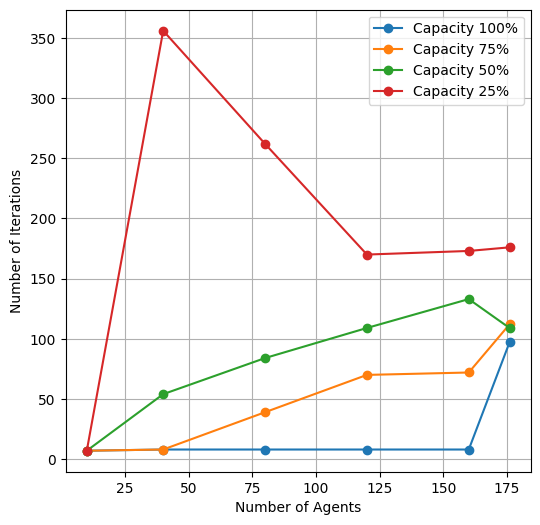

In [22]:
# Plotting the data
plt.figure(figsize=(6, 6))
# plt.title("Market Performance by Capacity")
plt.ylabel("Number of Iterations")
plt.xlabel("Number of Agents")
# plt.yticks(range(0, combined_df["Number_Interations"].max() + 10, 10))
plt.grid()
capacities = [100,75,50,25]
for capacity in combined_df["Capacity"].unique():
    if capacity == 13:
        cap = 100
    elif capacity == 10:
        cap = 75
    elif capacity == 7:
        cap = 50
    elif capacity == 4:
        cap = 25
    subset = combined_df[combined_df["Capacity"] == capacity]
    plt.plot(subset["Number_Agents"], subset["Number_Interations"], label=f"Capacity {cap}%", marker='o')

plt.legend()
current_dir = os.getcwd()
plt.savefig(f"{current_dir}/plots/nagents_niter.png")

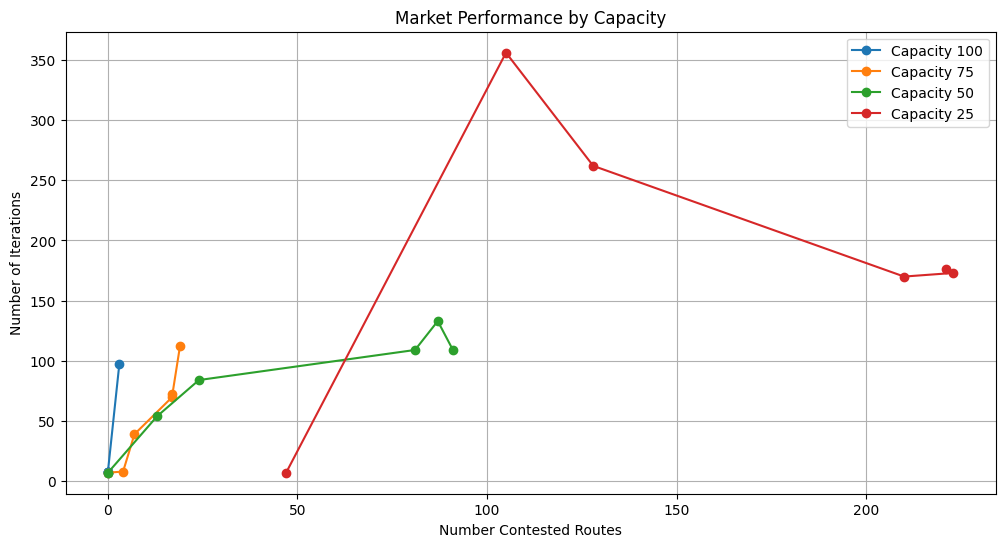

In [15]:
# Plotting the data
plt.figure(figsize=(12, 6))
plt.title("Market Performance by Capacity")
plt.ylabel("Number of Iterations")
plt.xlabel("Number Contested Routes")
plt.grid()
for capacity in combined_df["Capacity"].unique():
    if capacity == 13:
        cap = 100
    elif capacity == 10:
        cap = 75
    elif capacity == 7:
        cap = 50
    elif capacity == 4:
        cap = 25
    subset = combined_df[combined_df["Capacity"] == capacity]
    plt.plot(subset["Number_Contested_Routes"], subset["Number_Interations"], label=f"Capacity {cap}", marker='o')

plt.legend()



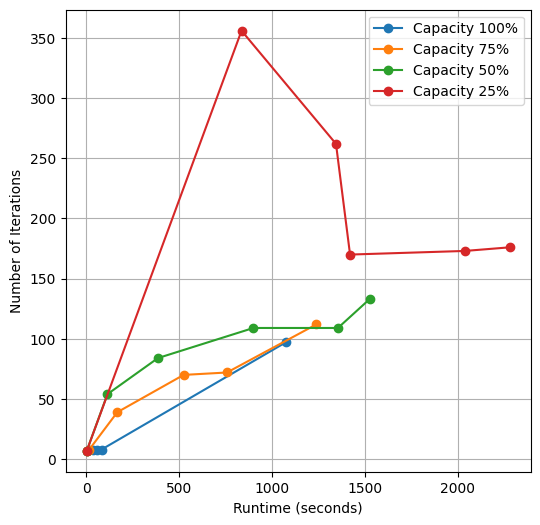

In [23]:
# Plotting the data
plt.figure(figsize=(6, 6))
# plt.title("Market Performance by Capacity")
plt.ylabel("Number of Iterations")
plt.xlabel("Runtime (seconds)")
plt.grid()
for capacity in combined_df["Capacity"].unique():
    if capacity == 13:
        cap = 100
    elif capacity == 10:
        cap = 75
    elif capacity == 7:
        cap = 50
    elif capacity == 4:
        cap = 25
    subset = combined_df[combined_df["Capacity"] == capacity]
    subset = subset.sort_values(by="Run_Time")
    plt.plot(subset["Run_Time"], subset["Number_Interations"], label=f"Capacity {cap}%", marker='o')
    # plt.plot(subset["Number_Interations"], subset["Run_Time"], label=f"Capacity {cap}%", marker='o')
    # plt.plot(subset["Run_Time"], subset["Number_Interations"], label=f"Capacity {capacity}", marker='o')

plt.legend()
plt.savefig(f"{current_dir}/plots/runtime_niter.png")

# Beta Study
## Reading multiple market performance files for every case adn every auction

In [2]:
current_dir = os.getcwd()
parent_folder = os.path.abspath(os.path.join(current_dir, ".."))
new_folder_path = os.path.join(parent_folder, "results", "beta_effect_MCE")
folder_list = [f.path for f in os.scandir(new_folder_path) if f.is_dir()]


In [3]:
df_list = []
df_method = []
for file in folder_list:
    folder_path = os.path.join(parent_folder, "results", file, "results")
    csv_file_path = os.path.join(folder_path, 'market_performance_table.csv')
    
    try:
        df_csv = pd.read_csv(csv_file_path)
        df_csv["File"] = file  # column to track file origin
        match = re.search(r"beta-method-([^\s_]+)", file)
        beta_method = match.group(1) if match else "Unknown"
        df_csv["Beta_Method"] = beta_method  # Add beta-method as a column
        df_list.append(df_csv)
    except FileNotFoundError:
        print(f"File not found: {csv_file_path}")
    except pd.errors.EmptyDataError:
        print(f"File is empty: {csv_file_path}")

# Concatenate all DataFrames
pd.set_option('display.max_rows', None) 

if df_list:
    combined_df = pd.concat(df_list, ignore_index=True)
    display(combined_df)
else:
    print("No data was loaded.")

,Market_Auction_Start_Time,Number_Interations,Number_Agents,Num_Goods,Num_ZeroCap_Goods,Number_Contested_Path,Number_Contested_DesGood,Run_Time,File,Beta_Method
0,0,5,10,686,2,30,2,2.24730,/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Me...,fixedlmb10K
1,10,24,13,771,10,69,7,14.37564,/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Me...,fixedlmb10K
2,20,5,12,809,12,58,12,2.60354,/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Me...,fixedlmb10K
3,30,127,17,924,14,106,20,107.89039,/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Me...,fixedlmb10K
4,40,23,13,724,16,75,19,14.70978,/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Me...,fixedlmb10K
5,50,5,13,714,10,80,10,3.15009,/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Me...,fixedlmb10K
6,60,5,11,834,10,38,10,2.65874,/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Me...,fixedlmb10K
7,70,1000,11,698,4,41,7,524.00090,/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Me...,fixedlmb10K
8,80,53,19,1000,13,143,26,48.63748,/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Me...,fixedlmb10K
9,90,87,19,1116,12,133,23,79.53346,/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Me...,fixedlmb10K


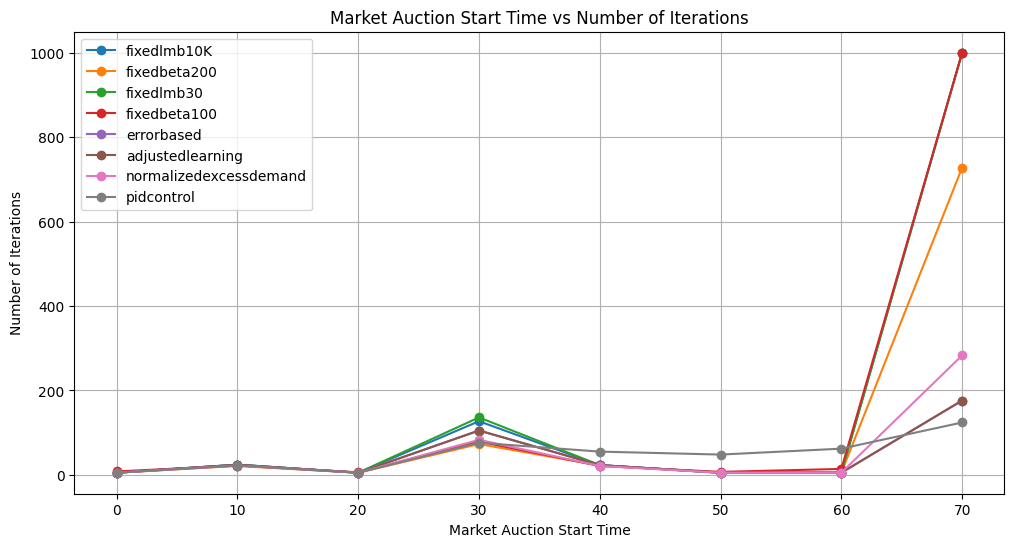

In [4]:
filtered_df = combined_df

# Filter the DataFrame based on the beta_method
# No filtering needed, keep all methods
# filtered_df = combined_df[combined_df["Beta_Method"] == beta_method
# Filter out the specified beta_method
beta_method_to_avoid = "excessdemand"
filtered_df = filtered_df[filtered_df["Beta_Method"] != beta_method_to_avoid]
# Plotting the data
plt.figure(figsize=(12, 6))
plt.title("Market Auction Start Time vs Number of Iterations")
plt.xlabel("Market Auction Start Time")
plt.ylabel("Number of Iterations")
plt.grid(True)

filtered_df = filtered_df[filtered_df["Market_Auction_Start_Time"] <= 70]
for method in filtered_df["Beta_Method"].unique():
    subset = filtered_df[filtered_df["Beta_Method"] == method]
    plt.plot(subset["Market_Auction_Start_Time"], subset["Number_Interations"], label=method, marker='o')

plt.legend()
plt.show()

# Alpha, studying tolerance (whisker plot)

In [22]:
current_dir = os.getcwd()
parent_folder = os.path.abspath(os.path.join(current_dir, ".."))
new_folder_path = os.path.join(parent_folder, "results", "alpha_study")
folder_list = [f.path for f in os.scandir(new_folder_path) if f.is_dir()]


In [23]:
df_list = []
df_method = []
for file in folder_list:
    folder_path = os.path.join(parent_folder, "results", file, "results")
    csv_file_path = os.path.join(folder_path, 'market_performance_table.csv')
    
    try:
        df_csv = pd.read_csv(csv_file_path)
        df_csv["File"] = file  # column to track file origin
        match = re.search(r"alpha-([^\s_]+)", file)
        alpha = match.group(1) if match else "Unknown"
        df_csv["alpha"] = alpha 
        df_list.append(df_csv)
    except FileNotFoundError:
        print(f"File not found: {csv_file_path}")
    except pd.errors.EmptyDataError:
        print(f"File is empty: {csv_file_path}")

# Concatenate all DataFrames
pd.set_option('display.max_rows', None) 

if df_list:
    combined_df = pd.concat(df_list, ignore_index=True)
    display(combined_df)
else:
    print("No data was loaded.")

,Market_Auction_Start_Time,Number_Interations,Number_Agents,Num_Goods,Num_ZeroCap_Goods,Number_Contested_Path,Number_Contested_DesGood,Run_Time,File,alpha
0,0,14,10,992,0,0,0,8.10692,/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Me...,0.1
1,20,16,14,1206,1,3,1,12.49775,/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Me...,0.1
2,40,14,12,1101,0,8,0,10.99292,/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Me...,0.1
3,60,1000,17,1359,0,10,5,1027.78032,/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Me...,0.1
4,80,11,11,934,0,1,0,6.64066,/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Me...,0.1
5,100,12,14,1065,0,12,0,8.69163,/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Me...,0.1
6,120,17,10,1156,0,1,0,10.54818,/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Me...,0.1
7,140,1000,12,1040,0,13,8,884.20778,/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Me...,0.1
8,160,327,20,1493,1,32,7,388.11947,/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Me...,0.1
9,180,16,16,1406,0,0,0,13.75749,/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Me...,0.1


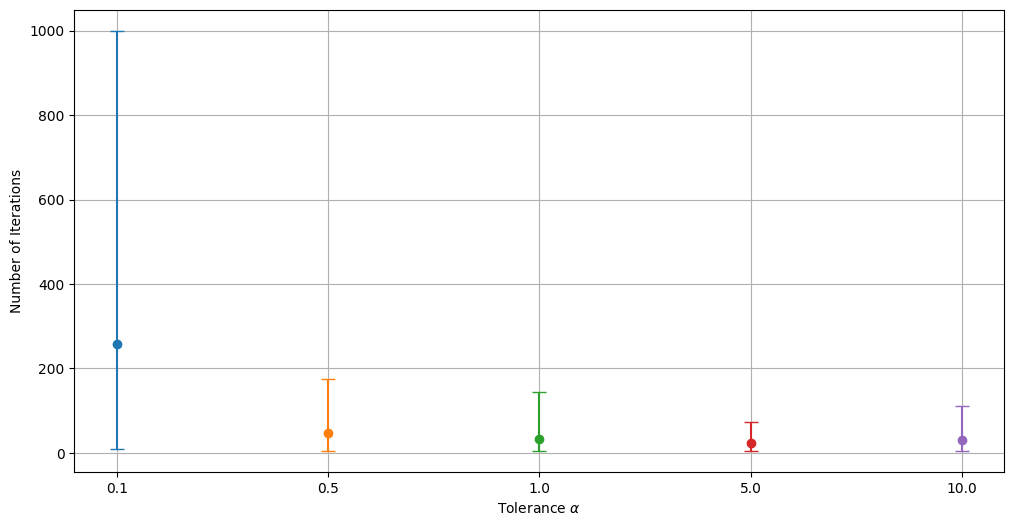

In [29]:
filtered_df = combined_df


plt.figure(figsize=(12, 6))
plt.xlabel(r'Tolerance $\alpha$')
plt.ylabel("Number of Iterations")
plt.grid(True)



alpha_stats = filtered_df.groupby(['alpha'])['Number_Interations'].agg(['mean', 'max', 'min']).reset_index()
alpha_stats = alpha_stats.sort_values(by='alpha', key=lambda x: x.astype(float))

for alpha_value in alpha_stats['alpha'].unique():
    subset = alpha_stats[alpha_stats['alpha'] == alpha_value]
    
    yerr = np.vstack([
        subset['mean'] - subset['min'], 
        subset['max'] - subset['mean']  
    ])
    
    plt.errorbar(
        subset['alpha'], 
        subset['mean'], 
        yerr=yerr, 
        fmt='o', capsize=5, label=f'Alpha {alpha_value}'
    )


plt.show()


# Lamba Study

In [30]:
current_dir = os.getcwd()
parent_folder = os.path.abspath(os.path.join(current_dir, ".."))
new_folder_path = os.path.join(parent_folder, "results", "lambda")
folder_list = [f.path for f in os.scandir(new_folder_path) if f.is_dir()]

In [31]:
df_list = []
df_method = []
for file in folder_list:
    folder_path = os.path.join(parent_folder, "results", file, "results")
    csv_file_path = os.path.join(folder_path, 'market_performance_table.csv')
    
    try:
        df_csv = pd.read_csv(csv_file_path)
        df_csv["File"] = file  # column to track file origin
        match = re.search(r"freq([^\s_]+)", file)
        lambda_val = match.group(1) if match else "Unknown"
        df_csv["Freq"] = lambda_val
        df_list.append(df_csv)
    except FileNotFoundError:
        print(f"File not found: {csv_file_path}")
    except pd.errors.EmptyDataError:
        print(f"File is empty: {csv_file_path}")

# Concatenate all DataFrames
pd.set_option('display.max_rows', None) 

if df_list:
    combined_df = pd.concat(df_list, ignore_index=True)
    display(combined_df)
else:
    print("No data was loaded.")

,Market_Auction_Start_Time,Number_Interations,Number_Agents,Num_Goods,Num_ZeroCap_Goods,Number_Contested_Path,Number_Contested_DesGood,Run_Time,File,Freq
0,0,40,80,4593,7,319,1,164.84030,/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Me...,25.0
1,0,39,80,4593,7,319,1,162.13004,/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Me...,20.0
2,0,39,80,4593,7,319,1,164.40834,/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Me...,30.0
3,0,47,80,4593,7,319,1,185.62133,/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Me...,5.0
4,0,39,80,4593,7,319,1,153.47589,/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Me...,10.0
5,0,48,80,4593,7,319,1,192.27300,/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Me...,2.0
6,0,38,80,4593,7,319,1,155.45424,/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Me...,15.0


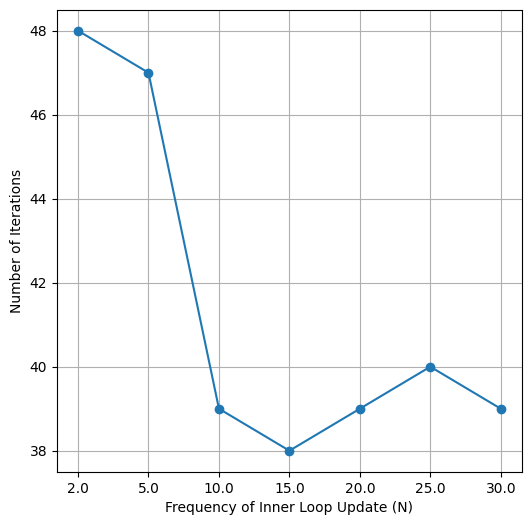

In [40]:
filtered_df = combined_df

plt.figure(figsize=(6, 6))

plt.xlabel("Frequency of Inner Loop Update (N)")
plt.ylabel("Number of Iterations")
plt.grid(True)
filtered_df = filtered_df.sort_values(by="Freq", key=lambda x: x.astype(float))

plt.plot(filtered_df["Freq"], filtered_df["Number_Interations"], marker='o')

# plt.show()
plt.savefig(f"{current_dir}/plots/lambda_niter.png")

# Percent/Number of drop-out vs Number of agents. 
### Read from result files the status of allocated

In [50]:
current_dir = os.getcwd()
parent_folder = os.path.abspath(os.path.join(current_dir, ".."))
new_folder_path = os.path.join(parent_folder, "results", "capacity_study")
folder_list = [f.path for f in os.scandir(new_folder_path) if f.is_dir()]
print(folder_list)

['/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Mechanism-Design-for-AAM/ic/results/capacity_study/toulouse_case_cap4_updated_fisher_b-50.0_agents80_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_185000', '/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Mechanism-Design-for-AAM/ic/results/capacity_study/toulouse_case_cap7_updated_fisher_b-50.0_agents177_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_210343', '/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Mechanism-Design-for-AAM/ic/results/capacity_study/toulouse_case_cap10_updated_fisher_b-50.0_agents10_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_161400', '/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Mechanism-Design-for-AAM/ic/results/capacity_study/toulouse_case_cap10_updated_fisher_b-50.0_agents120_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_161756', '/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Mechanism-Design-for-AAM/ic/results/capacity_study/toulouse_ca

In [71]:

summary_data = {}

for folder in folder_list:
    # Construct the new folder path
    new_folder_path = os.path.join(folder, "results")
    results_table_path = os.path.join(new_folder_path, "market_results_table.csv")
    performance_table_path = os.path.join(new_folder_path, "market_performance_table.csv")
    
    try:
        df_results = pd.read_csv(results_table_path)
        df_performance = pd.read_csv(performance_table_path)
        
        # Extract the capacity value from the folder name
        capacity = int(folder.split('_cap')[1].split('_')[0])
        
        # Count each unique value under the column 'Status'
        status_counts = df_results['Status'].value_counts().to_dict()
        
        # Get the number of agents
        num_agents = df_performance['Number_Agents'].iloc[0]
        
        # Prepare column names specific to this file
        file_key = f"{folder}_cap{capacity}"
        
        # Store data in a dictionary format
        summary_data[file_key] = {
            'Capacity': capacity,
            'Number_Agents': num_agents,
            'Allocated': status_counts.get('allocated', 0),
            'Delayed': status_counts.get('delayed', 0),
            'Dropped': status_counts.get('dropped', 0),
            'Rebased': status_counts.get('rebased', 0),
            "Parked": status_counts.get('parked', 0)
        }
        
        # Add unknown status categories dynamically
        for status, count in status_counts.items():
            if status not in ["allocated", "delayed", "dropped", "rebased", "parked"]:
                summary_data[file_key][f"Unknown_{status}"] = count
                
        summary_data[file_key]['Check'] = (
            summary_data[file_key]['Allocated'] +
            summary_data[file_key]['Delayed'] +
            summary_data[file_key]['Dropped'] +
            summary_data[file_key]['Rebased'] +
            summary_data[file_key]['Parked'] == num_agents
        )
        
        summary_data[file_key]["Percentage_Allocated"] = summary_data[file_key]["Allocated"] / num_agents * 100
        summary_data[file_key]["Percentage_Delayed"] = summary_data[file_key]["Delayed"] / num_agents * 100
        summary_data[file_key]["Percentage_Dropped"] = summary_data[file_key]["Dropped"] / num_agents * 100
        summary_data[file_key]["Percentage_Rebased"] = summary_data[file_key]["Rebased"] / num_agents * 100
        summary_data[file_key]["Percentage_Parked"] = summary_data[file_key]["Parked"] / num_agents * 100
        summary_data[file_key]["perfect_dropped_rebased"] = (summary_data[file_key]["Dropped"] + summary_data[file_key]["Rebased"]) / num_agents * 100
        
    except FileNotFoundError as e:
        print(f"File not found: {e}")
    except pd.errors.EmptyDataError as e:
        print(f"File is empty: {e}")

# Convert dictionary to DataFrame
if summary_data:
    df_status_summary = pd.DataFrame.from_dict(summary_data, orient='index')
    df_status_summary.fillna(0, inplace=True)
    display(df_status_summary)
else:
    print("No valid data collected.")


,Capacity,Number_Agents,Allocated,Delayed,Dropped,Rebased,Parked,Check,Percentage_Allocated,Percentage_Delayed,Percentage_Dropped,Percentage_Rebased,Percentage_Parked,perfect_dropped_rebased
/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Mechanism-Design-for-AAM/ic/results/capacity_study/toulouse_case_cap4_updated_fisher_b-50.0_agents80_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_185000_cap4,4,80,21,7,0,52,0,True,26.250000,8.750000,0.000000,65.000000,0.0,65.000000
/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Mechanism-Design-for-AAM/ic/results/capacity_study/toulouse_case_cap7_updated_fisher_b-50.0_agents177_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_210343_cap7,7,176,115,14,0,47,0,True,65.340909,7.954545,0.000000,26.704545,0.0,26.704545
/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Mechanism-Design-for-AAM/ic/results/capacity_study/toulouse_case_cap10_updated_fisher_b-50.0_agents10_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_161400_cap10,10,10,10,0,0,0,0,True,100.000000,0.000000,0.000000,0.000000,0.0,0.000000
/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Mechanism-Design-for-AAM/ic/results/capacity_study/toulouse_case_cap10_updated_fisher_b-50.0_agents120_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_161756_cap10,10,120,116,3,0,1,0,True,96.666667,2.500000,0.000000,0.833333,0.0,0.833333
/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Mechanism-Design-for-AAM/ic/results/capacity_study/toulouse_case_cap13_updated_fisher_b-50.0_agents177_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_155448_cap13,13,176,174,0,0,2,0,True,98.863636,0.000000,0.000000,1.136364,0.0,1.136364
/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Mechanism-Design-for-AAM/ic/results/capacity_study/toulouse_case_cap7_updated_fisher_b-50.0_agents160_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_172828_cap7,7,160,116,13,0,31,0,True,72.500000,8.125000,0.000000,19.375000,0.0,19.375000
/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Mechanism-Design-for-AAM/ic/results/capacity_study/toulouse_case_cap4_updated_fisher_b-50.0_agents120_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_191252_cap4,4,120,36,11,0,73,0,True,30.000000,9.166667,0.000000,60.833333,0.0,60.833333
/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Mechanism-Design-for-AAM/ic/results/capacity_study/toulouse_case_cap7_updated_fisher_b-50.0_agents80_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_170543_cap7,7,80,64,4,0,12,0,True,80.000000,5.000000,0.000000,15.000000,0.0,15.000000
/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Mechanism-Design-for-AAM/ic/results/capacity_study/toulouse_case_cap13_updated_fisher_b-50.0_agents120_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_155023_cap13,13,120,120,0,0,0,0,True,100.000000,0.000000,0.000000,0.000000,0.0,0.000000
/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Mechanism-Design-for-AAM/ic/results/capacity_study/toulouse_case_cap10_updated_fisher_b-50.0_agents160_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_162731_cap10,10,160,154,1,0,5,0,True,96.250000,0.625000,0.000000,3.125000,0.0,3.125000


In [ ]:
# Plotting the percent of dropped/rebased vs number of agents
plt.figure(figsize=(10, 6))
plt.title("Percent of Dropped/Rebased vs Number of Agents")
plt.xlabel("Number of Agents")
plt.ylabel("Percent of Dropped/Rebased")
plt.grid(True)

# Plot each capacity
for capacity in df_status_summary['Capacity'].unique():
    subset = df_status_summary[df_status_summary['Capacity'] == capacity]
    plt.plot(subset['Number_Agents'], subset['perfect_dropped_rebased'], label=f"Capacity {capacity}", marker='o')

plt.legend()
plt.show()